In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

##Standard library
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from scipy import stats
from scipy.stats import skew,kurtosis
from scipy.stats import kstest,ks_2samp

%matplotlib inline

/dds/miniconda/envs/dds/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
path_data = os.getcwd()

raw_data = 'raw/smartmeter_raw.csv'
tariffs = 'raw/Tariffs.csv'
infos = 'raw/UKPN-LCL-smartmeter-sample.csv'

In [ ]:
def calculate_indicators(df_raw):
    array = df_raw.values
    mean = np.apply_along_axis(np.mean,1,array)
    std = np.apply_along_axis(np.std,1,array)
    cv = np.divide(std,mean,out=np.zeros_like(std),where=mean!=0)
    skewness = np.apply_along_axis(skew,1,array)
    kurtosis_coeff = np.apply_along_axis(kurtosis,1,array)
    max_week = np.apply_along_axis(np.max,1,array)
    ratio_max_mean = np.divide(max_week,mean,out=np.zeros_like(max_week),where=mean!=0)
    
    df = pd.DataFrame({'mean':mean,'cv':cv,
                        'skewness':skewness,
                        'kurtosis':kurtosis_coeff,
                        'max_week':max_week,
                        'ratio_max_mean':ratio_max_mean})
    df.index = df_raw.index
    return df

In [35]:
df_conso = pd.read_csv(path_data+raw_data)
df_conso = df_conso.rename(columns={'KWH/hh (per half hour) ': 'p_value'})

In [38]:
df_info = df_conso.drop(['DateTime', 'p_value'], axis=1).set_index('LCLid')
df_info = df_info.reset_index().drop_duplicates(subset='LCLid', keep='first').set_index('LCLid')
df_info.to_csv(path_data+"processing/smartmeter_info.csv")

In [14]:
df_conso_1 = df_conso.pivot_table(index="LCLid",values="p_value",columns="DateTime", aggfunc='first')

df_conso_1.columns = pd.to_datetime(df_conso_1.columns, format="%Y-%m-%d %H:%M:%S")
difference = pd.date_range(start=df_conso_1.columns.min(), end=df_conso_1.columns.max(), freq="30min").difference(df_conso_1.columns)
df_conso_1 = pd.concat([df_conso_1,pd.DataFrame(columns = difference)])
df_conso_1 = df_conso_1[df_conso_1.columns.sort_values()]

df_conso_1.drop(df_conso_1.columns[df_conso_1.columns.second !=0], axis=1,inplace=True)
df_conso_1.drop(df_conso_1.columns[df_conso_1.columns.minute%30!=0], axis=1,inplace=True)
df_conso_1.drop(df_conso_1.columns[:31], axis=1, inplace=True)
df_conso_1.drop(df_conso_1.columns[:48], axis=1, inplace=True)

df_conso_1.to_csv(path_data+"processing/smartmeter_DateTime-cols.csv")

In [3]:
df_conso_1 = pd.read_csv(path_data+"processing/smartmeter_DateTime-cols.csv", index_col=0,header=0)

In [ ]:
cols = pd.MultiIndex.from_product([list(range(1,119)),list(range(1,337))])

df_conso_1.columns = cols
df_conso_2 = df_conso_1.stack(0)
df_conso_2.index.set_names('week', level=1, inplace=True)
df_conso_2.dropna(inplace=True)
df_conso_2.to_csv(path_data+"processing/smartmeter_week.csv")

In [75]:
df_inds = calculate_indicators(df_conso_2)
df_inds = pd.merge(df_inds.reset_index(), df_info.reset_index(), on=['LCLid'], how='inner').set_index(['LCLid','week'])
df_inds.to_csv(path_data+"processing/smartmeter_week_inds.csv")

In [ ]:
df_inds_mini = df_inds.sample(50000)
df_conso_mini = df_conso_2.loc[df_inds_mini.index]

df_inds_mini.to_csv(path_data+"processing/smartmeter_week_inds_mini.csv")
df_conso_mini.to_csv(path_data+"processing/smartmeter_week_mini.csv")

/dds/miniconda/envs/dds/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


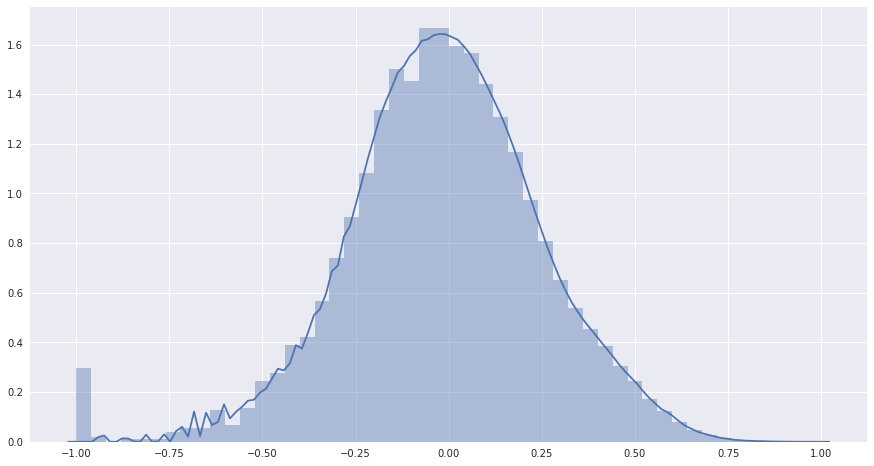

In [62]:
alpha=300
values = np.arcsinh(df_conso_2.sample(200000).values.flatten()*alpha)/alpha
values = 2*(values-values.min())/(values.max()-values.min())-1
sns.distplot(values,kde=True)

/dds/miniconda/envs/dds/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


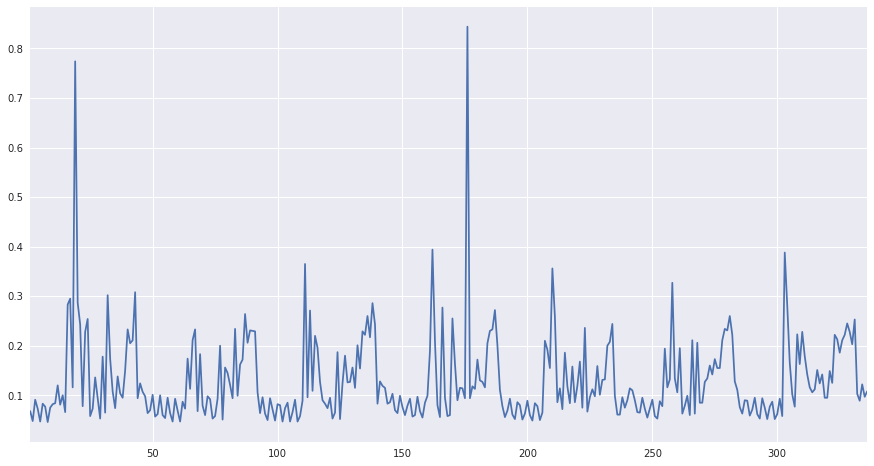

In [134]:
df_conso_2.iloc[np.random.choice(50000)].plot()